In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

print(tf.__version__)

rng = tf.random.Generator.from_seed(1234)

#Jupyter notebook commands
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


2.6.0


In [2]:
list_imgs = tf.data.Dataset.list_files('data/NN_training/images/*/*', shuffle=False)
list_mask = tf.data.Dataset.list_files('data/NN_training/masks/*/*', shuffle=False)
num_images = tf.data.experimental.cardinality(list_imgs).numpy()
num_masks  = tf.data.experimental.cardinality(list_mask).numpy()
assert num_images == num_masks

SHUFFLE_SEED = rng.uniform_full_int([1])[0].numpy()
list_imgs = list_imgs.shuffle(num_images, seed=SHUFFLE_SEED)
list_mask  = list_mask.shuffle(num_images, seed=SHUFFLE_SEED)

for f in list_imgs.take(5):
  print(f.numpy())
for f in list_mask.take(5):
  print(f.numpy())



flipper1 = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=SHUFFLE_SEED)
flipper2 = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=SHUFFLE_SEED)

def load_preprocess(imgpath, maskpath):
    img = tf.io.read_file(imgpath)
    img = tf.io.decode_image(img)
    # img = flipper1(img)
    # img = tf.image.stateless_random_brightness(img, 0.5, seed=SHUFFLE_SEED)
    # img = tf.image.stateless_random_contrast(img, 0.5, seed=SHUFFLE_SEED)
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape([128, 128, 3])

    mask = tf.io.read_file(maskpath)
    mask = tf.io.decode_image(mask, channels=1)
    mask = tf.math.greater(mask, tf.constant(50, dtype=tf.uint8))
    mask = tf.where(mask, 1, 0)
    # mask = flipper2(mask)
    mask.set_shape([128, 128, 1])

    return (img, mask)


ds = tf.data.Dataset.zip((list_imgs, list_mask)).map(load_preprocess, tf.data.AUTOTUNE)

BATCH_SIZE = 10

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds = configure_for_performance(ds)

# tf.data.experimental.save(ds, 'data/tfdataset')

b'data/NN_training/images/4J7A6522/3_3.jpg'
b'data/NN_training/images/4J7A6522/29_3.jpg'
b'data/NN_training/images/4J7A6522/2_15.jpg'
b'data/NN_training/images/4J7A6522/22_0.jpg'
b'data/NN_training/images/4J7A6522/22_22.jpg'
b'data/NN_training/masks/4J7A6522/3_3.jpg'
b'data/NN_training/masks/4J7A6522/29_3.jpg'
b'data/NN_training/masks/4J7A6522/2_15.jpg'
b'data/NN_training/masks/4J7A6522/22_0.jpg'
b'data/NN_training/masks/4J7A6522/22_22.jpg'


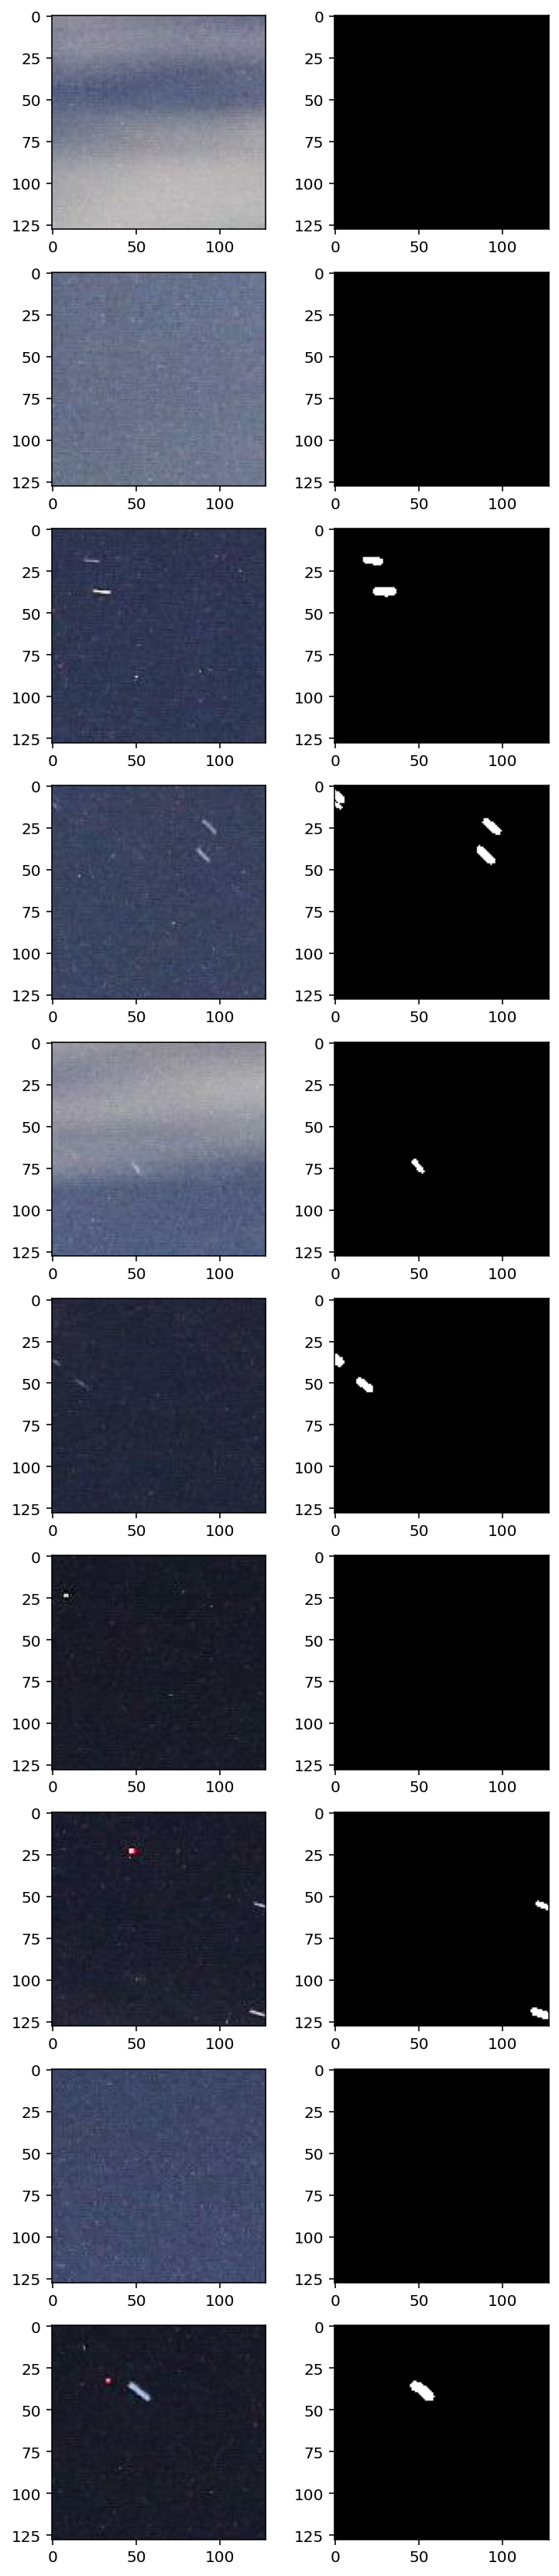

In [3]:
image_batch, mask_batch = next(iter(ds))

fig1 = plt.figure(figsize=(6,3*BATCH_SIZE))

for i in range(BATCH_SIZE):
    ax = plt.subplot(BATCH_SIZE, 2, 2*i+1)
    plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))
    ax = plt.subplot(BATCH_SIZE, 2, 2*i+2)
    plt.imshow(mask_batch[i].numpy(), cmap='gray', vmin=0, vmax=1)

plt.show()

In [4]:
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(12, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2D(12, 3, strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(24, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2D(24, 3, strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu'),
    
    tf.keras.layers.Conv2DTranspose(24, 3, strides=1, activation='relu'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(12, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2DTranspose(12, 3, strides=1, activation='relu'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(3, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=1, activation='relu'),
    # tf.keras.layers.Softmax(),
], name='NN_decoder')

model1.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy'])
model1.summary()

Model: "NN_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 12)      336       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 12)      1308      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 24)        2616      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 24)        5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 64)        1

In [5]:
model1.fit(ds, epochs=5, verbose=1)

Epoch 1/5
79/79 [==============================] - 13s 150ms/step - loss: 0.0035 - accuracy: 0.9963
Epoch 2/5
79/79 [==============================] - 11s 134ms/step - loss: 0.0027 - accuracy: 0.9968
Epoch 3/5
79/79 [==============================] - 11s 137ms/step - loss: 0.0023 - accuracy: 0.9972
Epoch 4/5
79/79 [==============================] - 11s 139ms/step - loss: 0.0021 - accuracy: 0.9975
Epoch 5/5
79/79 [==============================] - 11s 139ms/step - loss: 0.0019 - accuracy: 0.9976


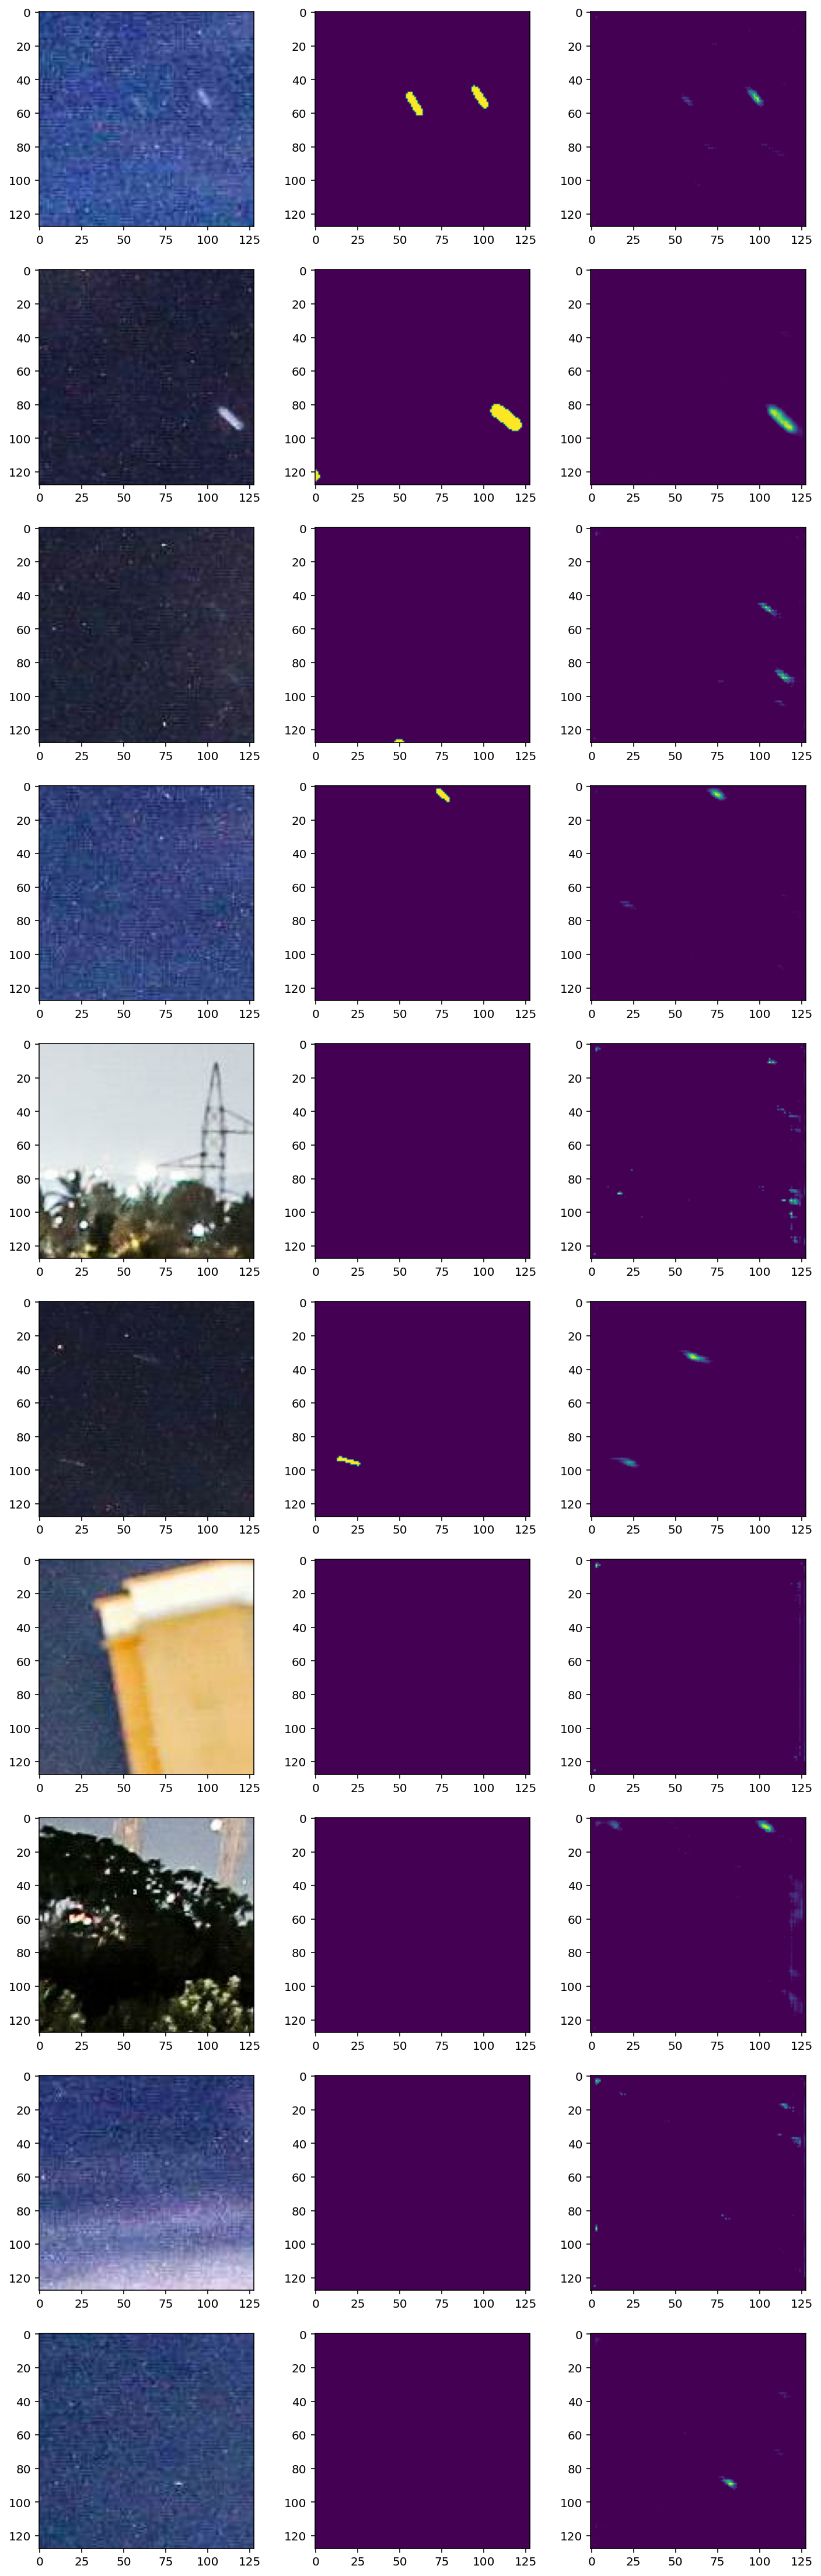

In [6]:
n = 1

for imgbatch, maskbatch in ds.take(n):

    fig2, ax2 = plt.subplots(BATCH_SIZE, 3, figsize=(12, 4*BATCH_SIZE))
    predbatch = model1.predict(imgbatch)

    for imgtest, masktest, pred, ax in zip(imgbatch, maskbatch, predbatch, ax2) :
        ax[0].imshow(tf.keras.utils.array_to_img(imgtest))
        ax[1].imshow(tf.keras.utils.array_to_img(masktest))
        ax[2].imshow(tf.keras.utils.array_to_img(pred))
        # print(pred.max(), pred.min(), masktest.numpy().max(), masktest.numpy().min())

        # plt.close('all')

In [7]:
model1.layers[0].get_weights()[0][:,:,:,0]
print(SHUFFLE_SEED)

472453817354278855
